In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from textblob import TextBlob
import spacy
import spacy.util
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
trans = preprocessing.MinMaxScaler()
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_train = pd.read_csv("data/feature_engineered/train_vars.csv", engine="python", on_bad_lines="skip")
print(df_train)

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [4]:
label_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [5]:
feature_cols = df_train.columns.difference(['text_id', 'full_text'] + label_cols).tolist()

In [6]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [ ]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        colwise_mse = self.mse(preds, targets).mean(dim=0)
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)
        display(colwise_rmse)
        return colwise_rmse.mean()

In [8]:
X = df_train[feature_cols]
y_all = df_train[label_cols]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_all, test_size=0.2, random_state=42
)

# train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# convert in torch.Tensor 
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) 

# calculate MCRMSE 
mcrmse_loss = MCRMSELoss()
loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

print(f"Evaluation mit MCRMSE: {loss_value.item():.4f}")

Evaluation mit MCRMSE: 0.5535


### Get Feature Importances

In [9]:
n_top_features = 30  

# Split data
y_all = df_train[label_cols].values
X_all = df_train[feature_cols].values

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Dict for Feature Importances
feature_importance_dict = {}

for i, label in enumerate(label_cols):
    y_train = y_train_full[:, i]

    # temp model
    temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
    temp_model.fit(X_train_full, y_train)

    # get Feature Importances 
    importances = temp_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    feature_importance_dict[label] = feature_importance_df

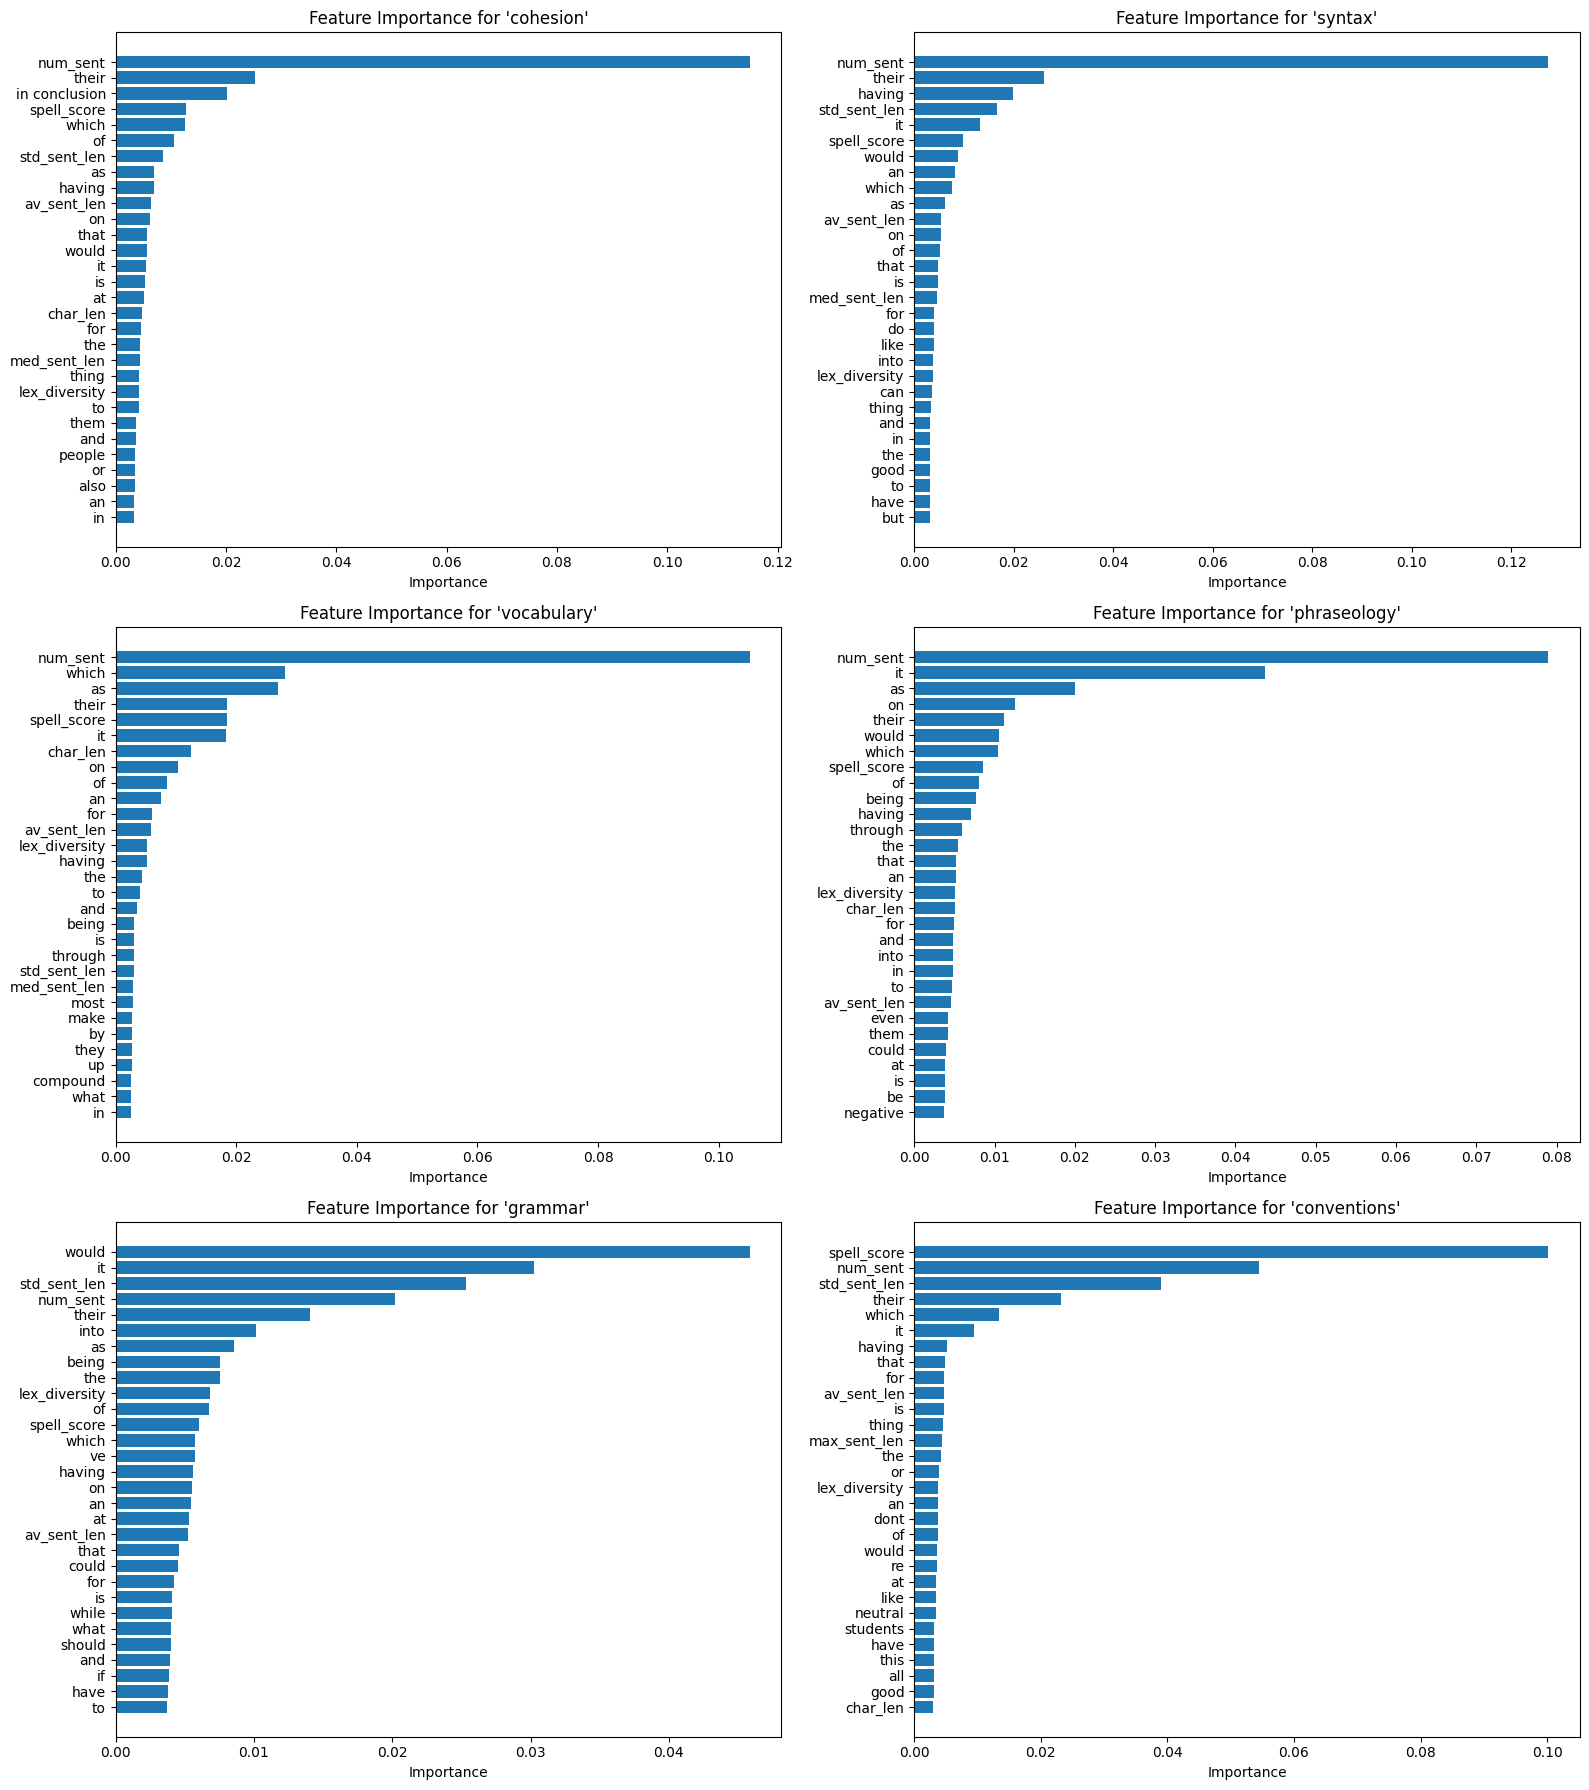

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# Plot für jedes Label
for i, label in enumerate(label_cols):
    feature_importance_df = feature_importance_dict[label]

    ax = axes[i]
    ax.barh(feature_importance_df['feature'][:n_top_features], 
            feature_importance_df['importance'][:n_top_features])
    ax.set_title(f"Feature Importance for '{label}'")
    ax.invert_yaxis()
    ax.set_xlabel("Importance")

plt.tight_layout()
plt.show()

### Using other models

- GradientBoostingRegressor
- HistGradientBoosting
- XGBRegressor
- LGBMRegressor